In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import keras
import keras_tuner as kt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold


In [11]:
data_path='/Users/yaminguo/Desktop/GYM/Work/LST/code/DLR/ABI_surfrad_match_2021_2023'

In [12]:
data_raw=pd.read_pickle(data_path)

In [13]:
data_raw.head()

,year,jday,month,day,hour,zen,dwsolar,qc_dwsolar,uwsolar,qc_uwsolar,...,lon,elv,ABI_time,sitename,CTH,DQF_CTH,CTT,DQF_CTT,COD,DQF_COD
0,2021.0,135.0,5.0,15.0,11.0,81.605500,19.495000,0.0,5.190000,0.0,...,-88.37,213.0,2021-05-15 11:00:00,Bondville,8184.037598,0.0,232.841751,0.0,1.997253,5.0
1,2021.0,135.0,5.0,15.0,17.0,21.810172,224.175862,0.0,49.563793,0.0,...,-88.37,213.0,2021-05-15 17:00:00,Bondville,9140.850586,0.0,231.789413,0.0,44.647648,0.0
2,2021.0,135.0,5.0,15.0,18.0,22.781296,218.757407,0.0,47.946296,0.0,...,-88.37,213.0,2021-05-15 18:00:00,Bondville,8186.479004,0.0,240.581726,0.0,29.348392,0.0
3,2021.0,135.0,5.0,15.0,21.0,51.781818,89.103030,0.0,18.872727,0.0,...,-88.37,213.0,2021-05-15 21:00:00,Bondville,8334.197266,0.0,237.959412,0.0,25.837328,0.0
4,2021.0,135.0,5.0,15.0,1.0,95.584310,-0.832759,0.0,0.112069,0.0,...,-88.37,213.0,2021-05-15 01:00:00,Bondville,968.716553,0.0,NaN,4.0,NaN,7.0


In [14]:
def cloudQC_filter(alldata):
    alldata.loc[alldata['DQF_CTH'] == 4, 'CTH'] = 0
    invalid_DQF_CTH = [3, 1, 6, 2, 5]
    alldata.loc[alldata['DQF_CTH'].isin(invalid_DQF_CTH), 'CTH'] = np.nan

    alldata.loc[alldata['DQF_CTT'] == 4, 'CTT'] = 0
    invalid_DQF_CTH = [3, 1, 6, 2, 5]
    alldata.loc[alldata['DQF_CTT'].isin(invalid_DQF_CTH), 'CTT'] = np.nan

    DQF_COD_raw = alldata['DQF_COD'].fillna(99).astype(int).values
    DQF_COD_mask = (DQF_COD_raw & 30)
    DQF_COD_mask2 = np.where(DQF_COD_raw == 99, np.nan, DQF_COD_mask)
    alldata['DQF_COD_msk'] = DQF_COD_mask2

    alldata.loc[alldata['DQF_COD_msk'] == 6, 'COD'] = 0
    invalid_DQF_COD = [2, 4, 8, 10, 12, 14, 16]
    alldata.loc[alldata['DQF_COD_msk'].isin(invalid_DQF_COD), 'COD'] = np.nan
    alldata = alldata.dropna()
    return alldata

In [15]:
data_raw=cloudQC_filter(data_raw)

# data_raw.head()

data_raw=data_raw[data_raw.pressure>0]
a=data_raw.describe()
a

/var/folders/n1/zydkpbg91lb27p4jtp0w1q340000gq/T/ipykernel_63148/122459390.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DQF_COD_raw = alldata['DQF_COD'].fillna(99).astype(int).values


,year,jday,month,day,hour,zen,dwsolar,qc_dwsolar,uwsolar,qc_uwsolar,...,windspd,qc_windspd,winddir,qc_winddir,pressure,qc_pressure,lat,lon,elv,DQF_COD_msk
count,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.0,126722.000000,126722.000000,...,126722.000000,126722.0,126722.000000,126722.0,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000
mean,2021.810175,177.823756,6.358880,15.619514,10.992669,92.797031,178.268159,0.0,36.245185,0.000276,...,3.655619,0.0,179.903929,0.0,944.686920,0.000017,40.446367,-96.935740,637.526988,2.615205
std,0.749011,105.743865,3.460278,8.768290,6.769923,38.000226,276.882231,0.0,157.647814,0.014720,...,2.592324,0.0,87.203300,0.0,56.542474,0.003977,4.216424,11.938579,507.825065,2.975232
min,2021.000000,1.000000,1.000000,1.000000,0.000000,12.795500,-7.388333,0.0,-9999.900000,0.000000,...,0.000000,0.0,0.000000,0.0,499.900000,0.000000,34.250000,-116.020000,98.000000,0.000000
25%,2021.000000,83.000000,3.000000,8.000000,5.000000,58.937250,-1.521667,0.0,-0.315000,0.000000,...,1.793333,0.0,110.786250,0.0,906.554167,0.000000,36.624000,-105.237000,213.000000,0.000000
50%,2022.000000,176.000000,6.000000,16.000000,10.000000,99.587833,-0.786667,0.0,0.093333,0.000000,...,3.038333,0.0,179.908333,0.0,963.265000,0.000000,40.125000,-96.620000,473.000000,0.000000
75%,2022.000000,269.000000,9.000000,23.000000,17.000000,122.095292,320.962083,0.0,72.551250,0.000000,...,4.918333,0.0,249.632917,0.0,988.333333,0.000000,43.730000,-88.370000,1007.000000,6.000000
max,2023.000000,365.000000,12.000000,31.000000,23.000000,168.450625,1146.026667,0.0,729.822222,1.000000,...,25.968333,0.0,355.363333,0.0,1025.970000,1.000000,48.310000,-77.930000,1689.000000,6.000000


In [16]:
features=['lat', 'lon', 'elv', 'jday', 'hour','zen', 'temp','rh','windspd', 'pressure','CTT','CTH','COD','year']
label=['dwir']

**Data Preprocessing**

In [ ]:
Y = data_raw[label]
X = data_raw[features]
Y.shape
X.shape

(126722, 14)

Text(0, 0.5, 'Frequency')

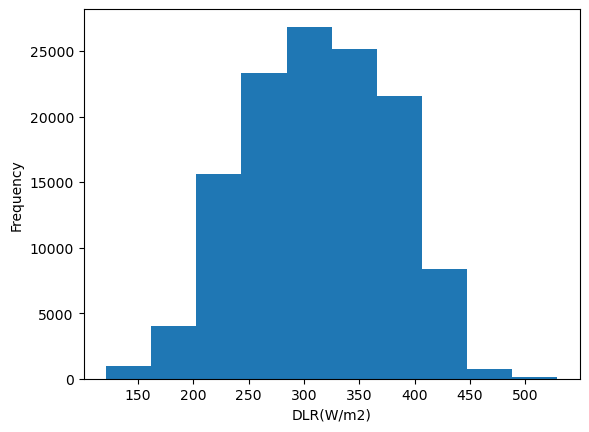

In [18]:
plt.hist(Y)
plt.xlabel('DLR(W/m2)')
plt.ylabel('Frequency')

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=6)

In [ ]:
# Train_alldata = data_raw.loc[data_raw.year != 2023]
# Test_alldata = data_raw.loc[data_raw.year == 2023]
# X_train = Train_alldata[features]
# X_test = Test_alldata[features]
# Y_train = Train_alldata[label]
# Y_test = Test_alldata[label]

In [ ]:
# Train_alldata = data_raw.loc[data_raw.elv != 213.0]
# Test_alldata = data_raw.loc[data_raw.elv == 213.0]
# X_train = Train_alldata[features]
# X_test = Test_alldata[features]
# Y_train = Train_alldata[label]
# Y_test = Test_alldata[label]

In [20]:
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

In [21]:
scaler_input.fit(X_train)
scaler_label.fit(Y_train)

MinMaxScaler()

In [22]:
X_train_scaled = scaler_input.transform(X_train)
Y_train_scaled = scaler_label.transform(Y_train)

In [ ]:
plt.hist(X_train_scaled[:,7])
plt.show()

In [23]:
def build_model(hp):
    model = keras.Sequential()

    # first hidden
    model.add(keras.layers.Dense(
        units=hp.Int("units_1", min_value=64, max_value=512, step=64),
        activation="relu",
        input_shape=(X_train.shape[1],)
    ))

    # sencond and third
    if hp.Boolean("use_second_layer"):
        model.add(keras.layers.Dense(
            units=hp.Int("units_2", min_value=32, max_value=256, step=32),
            activation="relu"
        ))
    if hp.Boolean("use_third_layer"):
        model.add(keras.layers.Dense(
            units=hp.Int("units_3", min_value=32, max_value=256, step=32),
            activation="relu"
        ))

    # Dropout 
    model.add(keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    ))

    # output
    model.add(keras.layers.Dense(1, activation="linear"))

    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse",
        metrics=["mae"]
    )
    
    
    return model

In [ ]:
# tuner = kt.RandomSearch(
#     build_model,
#     objective="val_loss",
#     max_trials=20,
#     executions_per_trial=1,
#     directory="tuner_dlr",
#     project_name="dlr_regression_kfold"
# )
# tuner.search(X_train_scaled, Y_train_scaled,
#              epochs=50,
#              validation_split=0.1,
#              validation_split=0.1,
#              callbacks=[keras.callbacks.EarlyStopping(patience=5)])

/Users/yaminguo/anaconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
class MyKFoldTuner(kt.RandomSearch):
    def run_trial(self, trial, X, Y, batch_size=32, epochs=50, n_splits=3, **fit_kwargs):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        val_scores = []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            Y_train, Y_val = Y[train_idx], Y[val_idx]

            model = self.hypermodel.build(trial.hyperparameters)

            model.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=epochs,
                      batch_size=batch_size,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                      **fit_kwargs)

            loss, mae = model.evaluate(X_val, Y_val, verbose=0)
            val_scores.append(mae)

        # 记录每个 trial 的平均验证 MAE
        self.oracle.update_trial(trial.trial_id, {'val_mae': np.mean(val_scores)})

In [30]:
tuner = MyKFoldTuner(
    hypermodel=build_model,
    objective='val_mae',
    max_trials=10,
    directory="tuner_dlr",
    project_name="dlr_regression_kfold"
)

# 自动调用我们自定义的 run_trial
tuner.search(X_train_scaled, Y_train_scaled, epochs=50, batch_size=32)

Trial 10 Complete [00h 01m 20s]
val_mae: 0.02753593089679877

Best val_mae So Far: 0.026024803519248962
Total elapsed time: 00h 12m 45s


In [31]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
units_1: 64
use_second_layer: False
use_third_layer: True
dropout: 0.1
learning_rate: 0.00018644399818542467
units_3: 192
units_2: 32


In [32]:

# 构建并训练最终模型
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50


/Users/yaminguo/anaconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 497us/step - loss: 0.0112 - mae: 0.0771 - val_loss: 0.0021 - val_mae: 0.0352
Epoch 2/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - loss: 0.0026 - mae: 0.0401 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 3/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.0023 - mae: 0.0372 - val_loss: 0.0020 - val_mae: 0.0349
Epoch 4/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - loss: 0.0021 - mae: 0.0357 - val_loss: 0.0017 - val_mae: 0.0307
Epoch 5/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 0.0020 - mae: 0.0345 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 6/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - loss: 0.0019 - mae: 0.0335 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 7/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - loss: 0.0018 - mae: 0.0329 - val_loss: 0.0016 - val_mae: 0.0296
Epoch 8/50
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - loss: 0.0018 - mae: 0.0322 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 9/50
2495/2495 ━━━━━━━━━━━━━━

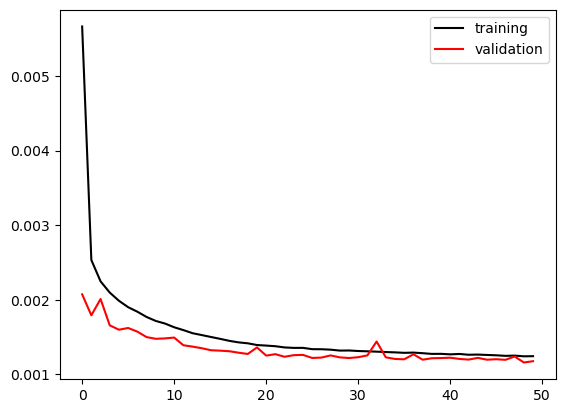

In [33]:
plt.plot(range(0,50), history.history['loss'], c='k', label='training')
plt.plot(range(0,50), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

Model

In [40]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 13,633 (53.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,268 (106.52 KB)

In [34]:
X_test_scaled = scaler_input.transform(X_test)
Y_test_scaled = scaler_label.transform(Y_test)

In [35]:
predictions = model.predict(
    x=X_test_scaled,
)

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


In [36]:
Pre_inverse=scaler_label.inverse_transform(predictions)
Y_test_inverse=scaler_label.inverse_transform(Y_test_scaled)

In [ ]:
def multipl(a,b):
    sumofab=0.0
    for i in range(len(a)):
        temp=a[i]*b[i]
        sumofab+=temp
    return sumofab
def correlation(x, y):
    n = len(x)
    sum1 = sum(x)
    sum2 = sum(y)
    sumofxy = multipl(x, y)
    sumofx2 = sum([pow(i, 2) for i in x])
    sumofy2 = sum([pow(j, 2) for j in y])
    num = sumofxy - (float(sum1) * float(sum2) / n)
    den = np.sqrt((sumofx2 - float(sum1 ** 2) / n) * (sumofy2 - float(sum2 ** 2) / n))
    r = num / den
    r2 = r * r
    return str('%.2f' % (r2))

def regress(x,y):
    from sklearn import  linear_model
    regr = linear_model.LinearRegression()
    t = np.array(x)
    t = np.array([x]).T
    regr.fit(t, y)
    #k = str('%.2f'%(regr.intercept_))
    #b = str('%.2f'%(regr.coef_))
    k = regr.coef_
    b = regr.intercept_
    KB = [k,b]
    return KB
def RMSE(x, y):
    rmse = np.sqrt(np.mean((x - y) ** 2))
    rmse = round(rmse, 2)
    return str('%.2f' % (rmse))


def MAE(x, y):
    mae = np.mean(abs(x - y))
    # mae = np.mean(x - y)
    mae = round(mae, 2)
    return str('%.2f' % (mae))
def plot_data(ax, x, y, Xmin, Xmax, Ymin, Ymax, Xinter, Yinter,Lables):
    from matplotlib.colors import LogNorm
    # z_min = 0
    # z_max = 500
    nbins = 100
    # global plot
    H, xedges, yedges = np.histogram2d(x, y, bins=nbins)
    H = np.rot90(H)
    H = np.flipud(H)
    # H_freq = H / H.sum()
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value of zero
    z_min_dynamic = Hmasked.min()
    z_max_dynamic = Hmasked.max()
    z_min = z_min_dynamic
    z_min = np.percentile(Hmasked.compressed(), 5)
    z_max = np.percentile(Hmasked.compressed(), 95)
    # norm = LogNorm(vmin=z_min, vmax=z_max)
    plot = ax.pcolormesh(xedges, yedges, Hmasked, cmap='jet', vmin=z_min, vmax=z_max)
    cbar = plt.colorbar(plot, ax=ax)
    # plot = ax.pcolormesh(xedges, yedges, Hmasked, cmap='jet', norm = LogNorm(vmin=z_min, vmax=z_max))
    # pt.colorbar()
    # cbar.ax.set_yticklabels(('0', '1', '2', '3', '4','5','6','7','8','9','10'),fontname='Calibri',fontsize=14,fontweight='bold')
    # cbar.ax.set_ylabel('Frequency')

    # y=x
    xx = [Xmin, Xmax]
    yy = [Xmin, Xmax]
    ax.plot(xx, yy, 'k--', linewidth=2.)

    aa = regress(x, y)
    ax.plot(x, x * aa[0] + aa[1], 'r', linewidth=1.)
    k = str('%.2f' % (aa[0]))
    b = str('%.2f' % (aa[1]))
    ax.set_ylim(Ymin, Ymax)
    ax.set_xlim(Xmin, Xmax)
    my_x_ticks = np.arange(Xmin, Xmax + Xinter, Xinter)
    my_y_ticks = np.arange(Ymin, Ymax + Yinter, Yinter)
    ax.set_xticks(my_x_ticks)
    ax.set_yticks(my_y_ticks)
    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)

    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)
    ax.text(Xmin + Xinter / 3, Ymax - Yinter / 3, r"N = " + str(len(x)),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 2 * Yinter / 3, r"R$^2$ = " + correlation(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 3 * Yinter / 3, r"RMSE = " + RMSE(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 4 * Yinter / 3, r"MAE = " + MAE(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 5 * Yinter / 3, r"Y = " + k + " X + " + b,
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title(Lables[2])
    # plt.colorbar()
    result = [len(x), correlation(x, y), RMSE(x, y), MAE(x, y), k, b]
    return result
def scatterplot(ax, Xdata, Ydata, Xmin, Xmax, Ymin, Ymax, Xinter, Yinter,Lables):
    from scipy.stats import gaussian_kde
    xy = np.vstack([Xdata, Ydata])  # 
    z = gaussian_kde(xy)(xy)  #
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = Xdata[idx], Ydata[idx], z[idx]

    plt.scatter(x, y, c=z, s=10, cmap='jet')  # c表示标记的颜色
    xx = [Xmin, Xmax]
    yy = [Xmin, Xmax]
    ax.plot(xx, yy, 'k--', linewidth=0.5)
    aa = regress(x, y)
    # ax.plot(x, x * aa[0] + aa[1], 'k', linewidth=0.5)
    k = str('%.2f' % (aa[0]))
    b = str('%.2f' % (aa[1]))
    ax.set_ylim(Ymin, Ymax)
    ax.set_xlim(Xmin, Xmax)
    my_x_ticks = np.arange(Xmin, Xmax + Xinter, Xinter)
    my_y_ticks = np.arange(Ymin, Ymax + Yinter, Yinter)
    ax.set_xticks(my_x_ticks)
    ax.set_yticks(my_y_ticks)
    # ax.set_xticklabels(('0', '5', '10', '15', '20'), fontname='Calibri', fontsize=16)
    # ax.set_yticklabels(('0', '5', '10', '15', '20'), fontname='Calibri', fontsize=16)
    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)
    ax.text(Xmin+Xinter/3, Ymax-Yinter/3, r"N = " + str(len(Xdata)),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-2*Yinter/3, r"R$^2$ = " + correlation(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-3*Yinter/3, r"RMSE = " + RMSE(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-4*Yinter/3, r"MAE = " + MAE(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter / 3, Ymax - 5 * Yinter / 3, r"Y = "+k+" X + "+b,
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title(Lables[2])
    plt.colorbar()
    result=[len(Xdata),correlation(Xdata, Ydata),RMSE(Xdata, Ydata),MAE(Xdata, Ydata),k,b]
    return result

In [38]:
Y_test_inverse2=Y_test_inverse.reshape(-1)
Pre_inverse2=Pre_inverse.reshape(-1)

In [ ]:
fig, ax = plt.subplots()
result_sites = scatterplot(ax, Y_test_inverse2, Pre_inverse2, 0, 1000, 0, 1000, 200, 200,
                               ['Measured DLR(W/m$^2$)', 'Prediction(W/m$^2$)',   'all sky'])

/var/folders/n1/zydkpbg91lb27p4jtp0w1q340000gq/T/ipykernel_63148/304093471.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = str('%.2f' % (aa[0]))
findfont: Font family 'Calibri' not found.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findf

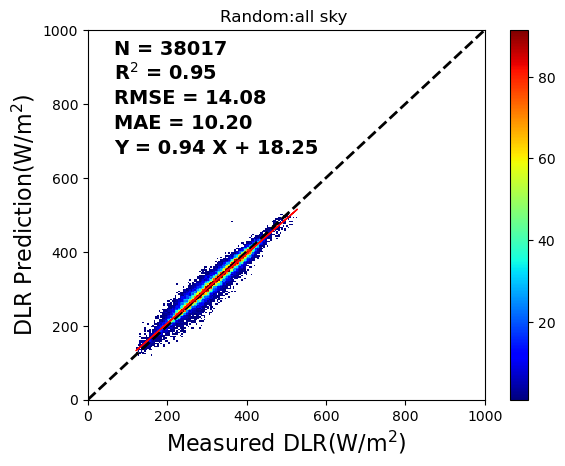

In [39]:
fig, ax = plt.subplots()
result_sites=plot_data(ax, Y_test_inverse2, Pre_inverse2,0, 1000, 0, 1000, 200, 200, ['Measured DLR(W/m$^2$)', 'DLR Prediction(W/m$^2$)', 'Random'+ ':all sky '])


In [41]:
model.save('ann_model_DLR_5Folds.h5')